# 🚀 Advanced Web Data Extraction with Crawl4AI: LinkedIn Discovery Tutorial

## What is this tutorial?

This notebook demonstrates **[Crawl4AI](https://github.com/unclecode/crawl4ai)'s advanced capabilities** through a real-world example: building a LinkedIn company and people discovery tool. You'll learn how to perform sophisticated web data extraction using AI-powered schema generation and structured data extraction.

## What will we build?

A **two-stage LinkedIn scraper** that:
1. **Discovers companies** based on search criteria (keywords + location)
2. **Extracts employees** from each company's "People" page
3. **Outputs structured data** in JSONL format ready for analysis

## Why is this approach powerful?

Traditional web data extraction requires manually writing CSS selectors for each element. Crawl4AI revolutionizes this by:
- **Auto-generating extraction schemas** using LLM (one-time process)
- **Reusing schemas** for fast, consistent data extraction
- **Handling dynamic content** with built-in browser automation
- **Scaling efficiently** without repeated LLM calls

## Prerequisites

- Google Colab environment (free tier is sufficient)
- LLM API key for schema generation (**Gemini recommended** - free tier available)
- Basic Python knowledge
- LinkedIn account (for manual HTML snippet collection)

## Tutorial Structure

### Step 0: Install Crawl4AI
Install the library with all dependencies

### Step 1: Environment Setup
Configure browser display using Crawl4AI's built-in setup methods

### Step 2: Import and Configuration
Initialize crawler and define search parameters

### Step 3: Prepare Schema Examples
Define target JSON structures and load HTML snippets

### Step 4: Generate Extraction Schemas (One-time)
Use LLM to analyze HTML and create reusable extraction patterns

### Step 5: Extract Companies
Search LinkedIn and extract company information

### Step 6: Extract People
For each company, extract employee profiles

### Step 7: Export Results
Save structured data in JSONL format for further processing


## LLM Options for Schema Generation

You can use **any LLM provider** for schema generation:
- **Google Gemini** (Recommended - free tier available)
- OpenAI GPT-4
- Anthropic Claude
- Local LLMs (Ollama, LM Studio)
- Any LangChain-compatible provider

The LLM is only used once to generate schemas, making this approach very cost-effective.

## Connect & Learn More

- 🐙 **GitHub**: [github.com/unclecode/crawl4ai](https://github.com/unclecode/crawl4ai)
- 🐦 **Follow on X**: [@unclecode](https://twitter.com/unclecode)
- 💬 **Join our Discord**: [discord.gg/jP8KfhDhyN](https://discord.gg/jP8KfhDhyN)

Join our community to share your projects, get help, and discover more advanced techniques!

## Important Notes

⚠️ **Respect LinkedIn's Terms of Service**: This tutorial is for educational purposes. Always follow website terms and implement appropriate rate limiting.

📝 **HTML Snippets**: For this tutorial, we provide sample HTML. In practice, you'd inspect LinkedIn pages and save HTML snippets yourself.

---

Let's begin by installing Crawl4AI! 👇

## Step 0: Install Crawl4AI

In [ ]:
%%capture
!git clone -b next https://github.com/unclecode/crawl4ai.git
!cp -r /content/crawl4ai/docs/apps/linkdin/{snippets,schemas} /content/
%cd crawl4ai
!uv pip install -e .
!crawl4ai-setup

In [ ]:
!crawl4ai-doctor

[INIT].... → Running Crawl4AI health check... 
[INIT].... → Crawl4AI 0.6.3 
[TEST].... ℹ Testing crawling capabilities... 
[EXPORT].. ℹ Exporting media (PDF/MHTML/screenshot) took 3.48s 
[FETCH]... ↓ https://crawl4ai.com                                               
| ✓ | ⏱: 7.48s 
[SCRAPE].. ◆ https://crawl4ai.com                                               
| ✓ | ⏱: 0.04s 
[COMPLETE] ● https://crawl4ai.com                                               
| ✓ | ⏱: 7.52s 
[COMPLETE] ● ✅ Crawling test passed! 


## Step 1: Environment Setup

In [ ]:
from crawl4ai import setup_colab_environment, start_colab_display_server

In [ ]:
%%capture
setup_colab_environment()

In [ ]:
start_colab_display_server()

## Step 2: Import, Configuration, and Build Identity

In [ ]:
import asyncio
import nest_asyncio, os
nest_asyncio.apply()
from urllib.parse import quote

from crawl4ai import AsyncWebCrawler, CrawlerRunConfig, BrowserConfig

os.environ["DISPLAY"] = ":99"

bc = BrowserConfig(
    headless=False, verbose=False,
    user_data_dir="/content/profiles/test_profile",
    use_managed_browser=True,
    extra_args = ["--display=:99"]
)

crawler = AsyncWebCrawler(config=bc)

async def start():
    await crawler.start()

async def close():
    await crawler.close()

asyncio.run(start())

In [ ]:
cfg = CrawlerRunConfig(
    wait_for = ".search-marvel-srp",
    session_id="company_search",
    delay_before_return_html=1,
    magic = True,
    verbose= False,
    page_timeout = 20 * 60 * 1000
)

query = "health insurance management"
geo=102713980

search_url = f'https://www.linkedin.com/search/results/companies/?keywords={quote(query)}&companyHqGeo="{geo}"'

async def main():
    # Run the crawler on a URL
    result = await crawler.arun(url=search_url, config=cfg)

    if result:
        # Print the extracted content
        print(result)
    else:
        print("No result found.")

# Run the async main function
asyncio.run(main())


CrawlResultContainer([CrawlResult(url='https://www.linkedin.com/search/results/companies/?keywords=health%20insurance%20management&companyHqGeo="102713980"', html='<!DOCTYPE html><html lang="en" class="theme theme--mercado app-loader--default artdeco"><head>\n    \n    <script nonce="">!function(i,n){void 0!==i.addEventListener&&void 0!==i.hidden&&(n.liVisibilityChangeListener=function(){i.hidden&&(n.liHasWindowHidden=!0)},i.addEventListener("visibilitychange",n.liVisibilityChangeListener))}(document,window);</script>\n    <meta name="trusted-types" content="script-src-attr \'none\'; require-trusted-types-for \'script\'; trusted-types \'allow-duplicates\' default jSecure highcharts dompurify goog#html" data-disposition="enforce" data-sanitizer="jSecure" data-report-to="https://www.linkedin.com/security/csp?a=voyager-web&amp;f=tt" http-equiv="Content-Security-Policy">\n\n    <title>(1) "health insurance management" | Search | LinkedIn</title>\n\n    <meta charset="utf-8">\n    <meta htt

## Step 3: Prepare Schema Examples

In [ ]:
from pathlib import Path

# Example of what we want to extract from company cards (exact structure matters!)
COMPANY_JSON_EXAMPLE = {
    "handle": "https://www.linkedin.com/company/posify/",
    "profile_image": "https://media.licdn.com/dms/image/v2/.../logo.jpg",
    "name": "Management Research Services, Inc. (MRS, Inc)",
    "descriptor": "Insurance • Milwaukee, Wisconsin",
    "about": "Insurance • Milwaukee, Wisconsin",
    "followers": "2k followers"
}

# Example of what we want to extract from people cards
PEOPLE_JSON_EXAMPLE = {
    "profile_url": "https://www.linkedin.com/in/lily-ng/",
    "name": "Lily Ng",
    "headline": "VP Product @ Posify",
    "followers": "10K followers",
    "connection_degree": "2nd",
    "avatar_url": "https://media.licdn.com/dms/image/v2/.../lily.jpg"
}

# Load the sample HTML snippets
# In Colab, you would either upload these files or paste the content directly
# For this tutorial, let's assume we have the HTML content as strings

# You can get these by:
# 1. Going to LinkedIn company/people search
# 2. Opening Chrome DevTools (F12)
# 3. Finding a company/person card element
# 4. Right-click → Copy → Copy outerHTML
SAMPLE_COMPANY_HTML = Path("/content/snippets/company.html").read_text()
SAMPLE_PEOPLE_HTML = Path("/content/snippets/people.html").read_text()

# If files don't exist, you can paste the HTML directly:
# SAMPLE_COMPANY_HTML = """<li class="...">...</li>"""
# SAMPLE_PEOPLE_HTML = """<li class="...">...</li>"""

# Print first 20 characters
print("Sample Company HTML:")
print(SAMPLE_COMPANY_HTML[:20])
print("\nSample People HTML:")
print(SAMPLE_PEOPLE_HTML[:20])

print("✅ Schema examples and HTML snippets loaded!")

Sample Company HTML:
<li class="kZRArQqqh

Sample People HTML:
<li class="grid grid
✅ Schema examples and HTML snippets loaded!


## Step 4: Generate Extraction Schemas (One-time)

In [ ]:
# Generate extraction schemas using LLM with exact prompts
from textwrap import dedent
from google.colab import userdata
from crawl4ai import JsonCssExtractionStrategy, LLMConfig
import json

# Define the exact schema generation prompts
COMPANY_SCHEMA_QUERY = dedent(
    """
    Using the supplied <li> company-card HTML, build a JsonCssExtractionStrategy schema that,
    for every card, outputs *exactly* the keys shown in the example JSON below.
    JSON spec:
      • handle        – Full url of the the company linkedin page, e.g. ""https://www.linkedin.com/company/[COMPANY-HANDLE]"
      • profile_image – URL of the company/entity logo image
      • name          – The main company name
      • descriptor    – text line with industry • location
      • about         – text comes usually after the follower ounts and is a summary of company.
      • followers     – Company account followers, e.g. "2k followers"

    IMPORTANT:
    0/ Do not use base64 kind of classes, they are temporary and not reliable
    1/ The main div parent contains these li element is "div.search-results-container" you can use this.
    The <ul> parent has "role" equal to "list". Using these two should be enough to target the <li> elements.
    2/ Remember there might be multiple <a> tags that start with https://www.linkedin.com/company/[NAME],
    so in case you refer to them for different fields, make sure to be more specific. One has the image, and one
    has the person's name.
    3/ Be very smart in selecting the correct and unique way to address the element. You should ensure
    your selector points to a single element and is unique to the place that contains the information.
    4/ Do not use Regex as much as possible.
    """
)

PEOPLE_SCHEMA_QUERY = dedent(
    """
    Using the supplied <li> people-card HTML, build a JsonCssExtractionStrategy schema that
    outputs exactly the keys in the example JSON below.
    Fields:
      • profile_url        – href of the outermost profile link
      • avatar_url         – src of the <img> usually within the a link.
      • name               – Person name
      • headline           – The person designation, usually come after their name and connection degree. (e.g. ABC Executive Editor | XYZ CEO at MBC. )
      • followers          – Follower count from the <div> containing the word "followers"

    IMPORTANT:
    0/ Do not use base64 kind of classes, they are temporary and not reliable
    1/ The main div parent contains these li element is a "div" has these classes
    "artdeco-card org-people-profile-card__card-spacing org-people__card-margin-bottom".
    2/ Be very smart in selecting the correct and unique way to address the element. You should ensure
    your selector points to a single element and is unique to the place that contains the information.
    3/ Try to avoid Regex as much as possible.
    """
)

async def load_or_build_schema(
    path: Path,
    sample_html: str,
    query: str,
    example_json: dict,
    force: bool = False
) -> dict:
    """Load schema from path, else call generate_schema once and persist."""
    if path.exists() and not force:
        print(f"📌 Loading existing schema: {path.name}")
        return json.loads(path.read_text())

    print(f"🤖 Generating schema: {path.name}")
    schema = JsonCssExtractionStrategy.generate_schema(
        html=sample_html,
        schema_type = "XPATH",
        llm_config=LLMConfig(
            # provider=os.getenv("C4AI_SCHEMA_PROVIDER", "openai/gpt-4.1"),
            # provider=os.getenv("C4AI_SCHEMA_PROVIDER", "openai/o3"),
            # api_token=userdata.get('OPENAI_API_KEY'),
            provider=os.getenv("C4AI_SCHEMA_PROVIDER", "gemini/gemini-2.5-flash-preview-05-20"),
            # provider=os.getenv("C4AI_SCHEMA_PROVIDER", "gemini/gemini-2.5-pro-preview-05-06"),
            api_token=userdata.get('GEMINI_API_KEY'),
        ),
        query=query,
        target_json_example=json.dumps(example_json, indent=2),
        temperature=1
    )
    path.write_text(json.dumps(schema, indent=2))
    return schema

# Generate or load schemas
company_schema = await load_or_build_schema(
    Path("/content/schemas/company_card.json"),
    SAMPLE_COMPANY_HTML,
    COMPANY_SCHEMA_QUERY,
    COMPANY_JSON_EXAMPLE,
    force=False  # Set to True to regenerate
)

people_schema = await load_or_build_schema(
    Path("/content/schemas/people_card.json"),
    SAMPLE_PEOPLE_HTML,
    PEOPLE_SCHEMA_QUERY,
    PEOPLE_JSON_EXAMPLE,
    force=False  # Set to True to regenerate
)

print("✅ Schemas ready!")
print(f"\n📋 Company Schema: { json.dumps(company_schema, indent=2) }")
print(f"\n📋 People Schema: { json.dumps(people_schema, indent=2) }")

📌 Loading existing schema: company_card.json
📌 Loading existing schema: people_card.json
✅ Schemas ready!

📋 Company Schema: {
  "name": "LinkedIn Company Search Result Card",
  "baseSelector": "div[data-chameleon-result-urn][data-view-name=\"search-entity-result-universal-template\"]",
  "baseFields": [
    {
      "name": "chameleon_result_urn",
      "type": "attribute",
      "attribute": "data-chameleon-result-urn"
    },
    {
      "name": "view_name",
      "type": "attribute",
      "attribute": "data-view-name"
    }
  ],
  "fields": [
    {
      "name": "handle",
      "selector": "div.mb1 div.display-flex span a[data-test-app-aware-link]",
      "type": "attribute",
      "attribute": "href"
    },
    {
      "name": "profile_image",
      "selector": "div.ivm-image-view-model img",
      "type": "attribute",
      "attribute": "src"
    },
    {
      "name": "name",
      "selector": "div.mb1 div.display-flex span a[data-test-app-aware-link]",
      "type": "text"
    }

## Step 5: Extract Companies

In [ ]:
from datetime import datetime
from pytz import UTC
import json

# Search and extract companies
MAX_COMPANIES = 2
QUERY = "health insurance management"
GEO_ID = 102713980

"""
| Location                | GEO_ID     |
|-------------------------|------------|
| Singapore               | 102713980  |
| Malaysia                | 104035573  |
| United States           | 103644278  |
| United Kingdom          | 101165590  |
| London Area             | 90009496   |
| California, US          | 102095887  |
| Texas, US               | 102748797  |
| New York, US            | 105080838  |
| Dubai, UAE              | 104305776  |
| Australia               | 101452733  |
| India                   | 102713980  |
| Toronto, Canada         | 90000070   |
| Paris, France           | 101620260  |
| Berlin, Germany         | 101282230  |
| Jakarta, Indonesia      | 103507420  |
| São Paulo, Brazil       | 106057199  |
| Tokyo, Japan            | 103644742  |
| Seoul, South Korea      | 104738515  |
| Bangkok, Thailand       | 104737807  |
| Ho Chi Minh City, VN    | 106815797  |
"""

# Utility function to parse follower counts
def openai_friendly_number(text: str) -> int:
    """Extract first int from text like '1K followers' (returns 1000)."""
    import re

    m = re.search(r"(\d[\d,]*)", text.replace(",", ""))
    if not m:
        return None
    val = int(m.group(1))
    if "k" in text.lower():
        val *= 1000
    if "m" in text.lower():
        val *= 1_000_000
    return val

async def scrape_companies(crawler, company_schema):
    """
    Stage 1: Search LinkedIn for companies and extract their information
    """
    # Build LinkedIn company search URL
    search_url = f'https://www.linkedin.com/search/results/companies/?keywords={quote(QUERY)}&companyHqGeo=[{GEO_ID}]'
    print(f"🔍 Searching: {search_url}")

    # Create extraction strategy with our schema
    extraction_strategy = JsonCssExtractionStrategy(company_schema)

    # Configure the crawler
    config = CrawlerRunConfig(
        extraction_strategy=extraction_strategy,
        wait_for=".search-results-container",  # Wait for results to load
        delay_before_return_html=2
    )

    # Crawl the page
    result = await crawler.arun(search_url, config=config)

    # Parse extracted data
    companies = json.loads(result.extracted_content)
    # print(companies)

    # Process and clean the data
    processed_companies = []
    for company in companies:
        handle = company.get('handle', '').strip()
        name = company.get('name', '').strip()

        followers = openai_friendly_number(str(company.get('followers', '')))

        # Build people_url based on whether handle is full URL or relative path
        if handle.startswith('http'):
            people_url = f"{handle}people/"
        else:
            people_url = f"https://www.linkedin.com{handle}people/"

        processed_companies.append({
            'handle': handle,
            'name': name,
            'descriptor': company.get('descriptor', ''),
            'about': company.get('about', ''),
            'followers': followers,
            'followers_str': company.get('followers', ''),
            'people_url': people_url,  # Now always a full URL
            'scraped_at': datetime.now(UTC).isoformat()
        })

    # Save to file
    os.makedirs('/content/output', exist_ok=True)
    with open('/content/output/companies.jsonl', 'w') as f:
        for company in processed_companies:
            f.write(json.dumps(company) + '\n')

    print(f"✅ Found {len(processed_companies)} companies")
    return processed_companies

# Load company schema
company_schema = json.loads(Path("/content/schemas/company_card.json").read_text())

# Execute company scraping
companies = await scrape_companies(crawler, company_schema)

# Display results
for i, company in enumerate(companies[:3], 1):
    print(f"\n{i}. {company['name']}")
    print(json.dumps(company, indent=2))


🔍 Searching: https://www.linkedin.com/search/results/companies/?keywords=health%20insurance%20management&companyHqGeo=[102713980]


[FETCH]... ↓ https://www.linkedin.com/search/results/companie...th insurance management&companyHqGeo=[102713980]  |
✓ | ⏱: 32.48s 

[SCRAPE].. ◆ https://www.linkedin.com/search/results/companie...th insurance management&companyHqGeo=[102713980]  |
✓ | ⏱: 0.58s 

[EXTRACT]. ■ Completed for https://www.linkedin.com/search/results/companies/... | Time: 0.5229513499998575s 

[COMPLETE] ● https://www.linkedin.com/search/results/companie...th insurance management&companyHqGeo=[102713980]  |
✓ | ⏱: 33.64s 

✅ Found 10 companies

1. HEALTH INSURANCE TPA OF INDIA LIMITED
{
  "handle": "https://www.linkedin.com/company/health-insurance-tpa-of-india-limited/",
  "name": "HEALTH INSURANCE TPA OF INDIA LIMITED",
  "descriptor": "Insurance \u2022 Noida, U.P",
  "about": "HealthInsuranceTPA of India Ltd is a joint venture of public sector Non-lifeinsurancecompanies \u2013NationalInsuranceCo. Ltd, the OrientalInsuranceCo. Ltd, The New India Assurance Co. Ltd, United IndiaInsuranceCo. Ltd and GIC of India.  The Company was incorporated in the year 2013 and has its Corporate office...",
  "followers": 837,
  "followers_str": "837",
  "people_url": "https://www.linkedin.com/company/health-insurance-tpa-of-india-limited/people/",
  "scraped_at": "2025-05-25T12:56:54.446351+00:00"
}

2. Health Plus Home Health Care
{
  "handle": "https://www.linkedin.com/company/health-plus-home-health-care/",
  "name": "Health Plus Home Health Care",
  "descriptor": "Home Health Care Services \u2022 Kolkata, West Beng

## Step 6: Scrape People

In [ ]:
MAX_PEOPLE_PER_COMPANY = 1

# Cell 5: Extract people from each company

async def scrape_people_from_company(crawler, company, people_schema):
    """
    Stage 2: For a given company, extract people who work there
    """
    people_url = company['people_url']
    print(f"  👥 Scanning: {company['name']}")

    # Create extraction strategy
    extraction_strategy = JsonCssExtractionStrategy(people_schema)

    # Configure crawler for people pages
    config = CrawlerRunConfig(
        extraction_strategy=extraction_strategy,
        wait_for=".org-people-profile-card__profile-card-spacing",
        delay_before_return_html=2,
        magic=True,
    )

    # Crawl the page
    result = await crawler.arun(people_url, config=config)

    # print(result.extracted_content)

    # Parse and process people
    people = json.loads(result.extracted_content)
    processed_people = []

    for person in people:
        processed_people.append({
            'profile_url': person.get('profile_url', ''),
            'name': person.get('name', "N/A"),
            'headline': person.get('headline', ''),
            'connection_degree': person.get('connection_degree', ''),
            'company_handle': company['handle'],
            'company_name': company.get('name', ''),
            'followers': person.get('followers', ''),
            'avatar_url': person.get('avatar_url', ''),
            'scraped_at': datetime.now(UTC).isoformat()
        })

    return processed_people

# Scrape people from all companies
all_people = []
for company in companies[:2]:  # Limit to first 3 companies for demo
    people = await scrape_people_from_company(crawler, company, people_schema)
    all_people.extend(people)
    print(f"    Found {len(people)} people")
    await asyncio.sleep(1)  # Be respectful with rate limiting

# Save all people to file
with open('/content/output/people.jsonl', 'w') as f:
    for person in all_people:
        f.write(json.dumps(person) + '\n')

print(f"\n✅ Total people found: {len(all_people)}")

# Display sample results
print("\n📊 Sample Results:")
for person in all_people[:5]:
    print(f"- {person['name']} | {person['headline']} @ {person['company_name']}")

  👥 Scanning: HEALTH INSURANCE TPA OF INDIA LIMITED


[FETCH]... ↓ https://www.linkedin.com/company/health-insurance-tpa-of-india-limited/people/                       |
✓ | ⏱: 16.43s 

[SCRAPE].. ◆ https://www.linkedin.com/company/health-insurance-tpa-of-india-limited/people/                       |
✓ | ⏱: 0.52s 

[EXTRACT]. ■ Completed for https://www.linkedin.com/company/health-insurance-... | Time: 0.11808275299972593s 

[COMPLETE] ● https://www.linkedin.com/company/health-insurance-tpa-of-india-limited/people/                       |
✓ | ⏱: 17.08s 

    Found 12 people
  👥 Scanning: Health Plus Home Health Care


[FETCH]... ↓ https://www.linkedin.com/company/health-plus-home-health-care/people/                                |
✓ | ⏱: 18.84s 

[SCRAPE].. ◆ https://www.linkedin.com/company/health-plus-home-health-care/people/                                |
✓ | ⏱: 0.21s 

[EXTRACT]. ■ Completed for https://www.linkedin.com/company/health-plus-home-... | Time: 0.07261508100054925s 

[COMPLETE] ● https://www.linkedin.com/company/health-plus-home-health-care/people/                                |
✓ | ⏱: 19.13s 

    Found 1 people

✅ Total people found: 13

📊 Sample Results:
- N/A | -- @ HEALTH INSURANCE TPA OF INDIA LIMITED
- N/A | Assistant Manager Claims at Health Insurance TPA of India Ltd. @ HEALTH INSURANCE TPA OF INDIA LIMITED
- N/A | investigator @ HEALTH INSURANCE TPA OF INDIA LIMITED
- N/A | Doctor - Claims @ HEALTH INSURANCE TPA OF INDIA LIMITED
- Dr.pawan bansiwal | Hospital & Health Care Professional @ HEALTH INSURANCE TPA OF INDIA LIMITED


## Step 7 Visualization

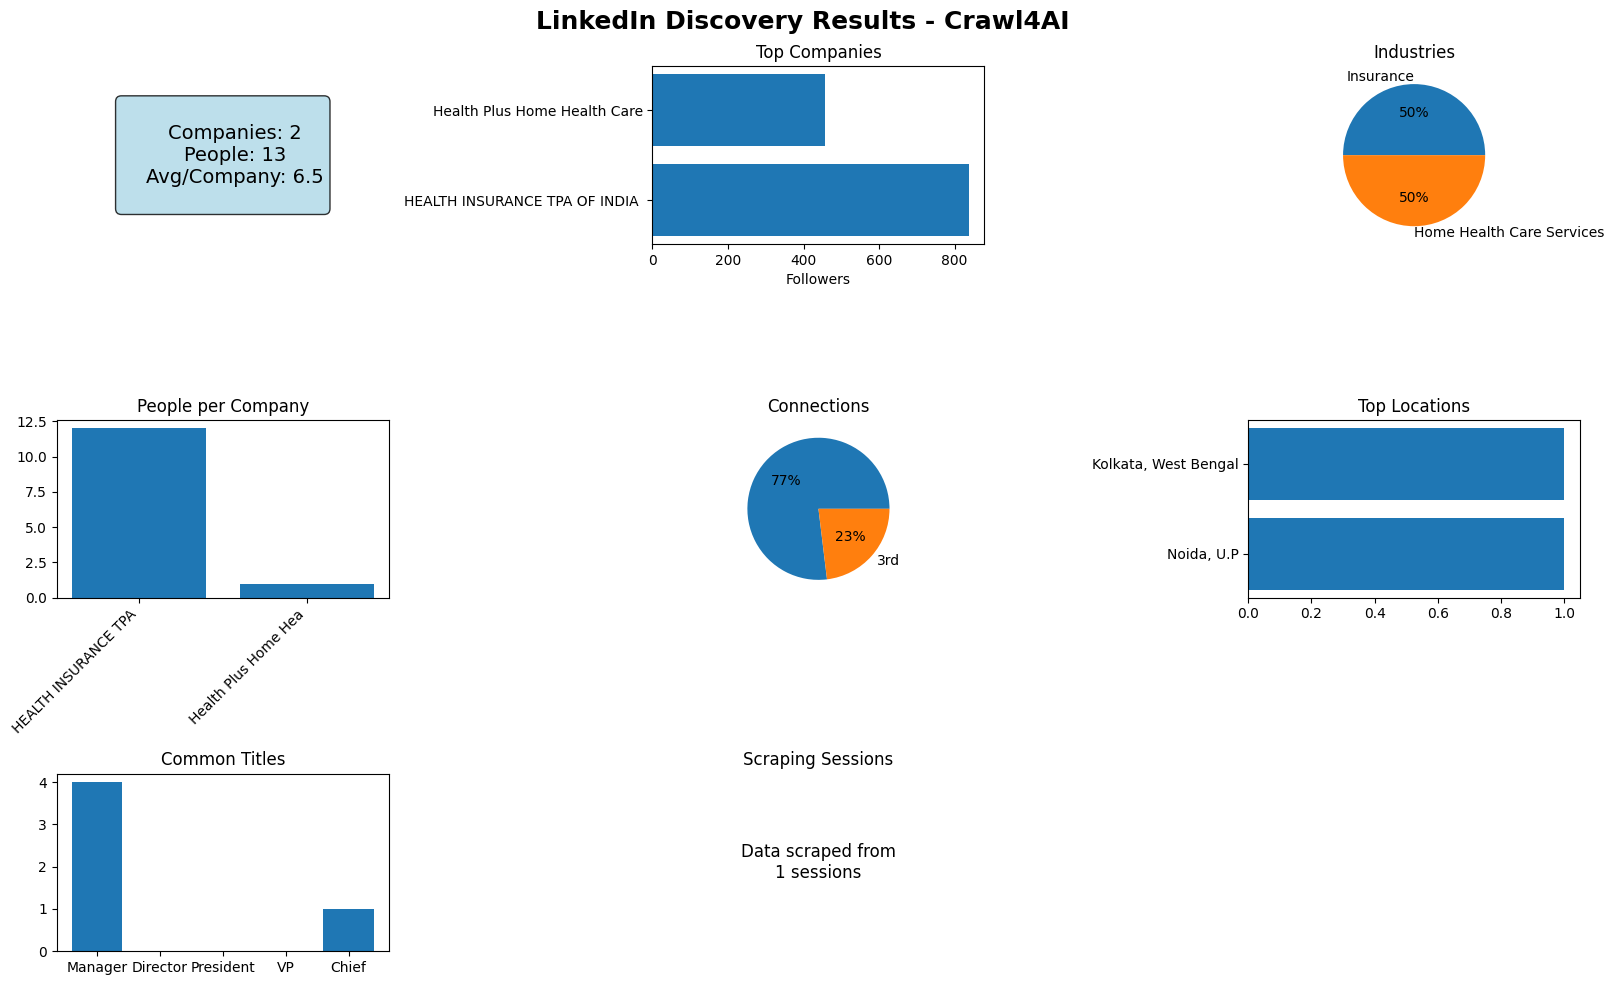


📊 Scraped 2 companies and 13 people
💾 Visualization saved to /content/output/results.png


In [ ]:
# Cell 7: Data Visualization

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def visualize_linkedin_data():
    """Visualize LinkedIn scraping results"""

    companies = []
    with open('/content/output/companies.jsonl', 'r') as f:
        for line in f:
            companies.append(json.loads(line))

    people = []
    with open('/content/output/people.jsonl', 'r') as f:
        for line in f:
            people.append(json.loads(line))

    df_companies = pd.DataFrame(companies)
    df_people = pd.DataFrame(people)

    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('LinkedIn Discovery Results - Crawl4AI', fontsize=18, fontweight='bold')

    # Summary
    ax_summary = plt.subplot(3, 3, 1)
    ax_summary.axis('off')
    summary = f"""
    Companies: {len(companies)}
    People: {len(people)}
    Avg/Company: {len(people)/len(companies):.1f}
    """
    ax_summary.text(0.5, 0.5, summary, transform=ax_summary.transAxes,
                   fontsize=14, ha='center', va='center',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    # Top Companies by Followers
    ax1 = plt.subplot(3, 3, 2)
    top_companies = df_companies[df_companies['followers'].notna()].nlargest(8, 'followers')
    if not top_companies.empty:
        ax1.barh(top_companies['name'].str[:30], top_companies['followers'])
        ax1.set_xlabel('Followers')
        ax1.set_title('Top Companies')

    # Industry Distribution
    ax2 = plt.subplot(3, 3, 3)
    industries = [desc.split('•')[0].strip() for desc in df_companies['descriptor']
                 if pd.notna(desc) and '•' in desc]
    industry_counts = Counter(industries).most_common(6)
    if industry_counts:
        labels, values = zip(*industry_counts)
        ax2.pie(values, labels=labels, autopct='%1.0f%%')
        ax2.set_title('Industries')

    # People per Company
    ax3 = plt.subplot(3, 3, 4)
    people_count = df_people.groupby('company_handle').size().sort_values(ascending=False)[:8]
    company_names = {c['handle']: c['name'][:20] for c in companies}
    labels = [company_names.get(h, h.split('/')[-2][:15]) for h in people_count.index]
    ax3.bar(range(len(labels)), people_count.values)
    ax3.set_xticks(range(len(labels)))
    ax3.set_xticklabels(labels, rotation=45, ha='right')
    ax3.set_title('People per Company')

    # Connection Degrees
    ax4 = plt.subplot(3, 3, 5)
    connections = df_people['connection_degree'].value_counts()
    if not connections.empty:
        ax4.pie(connections.values, labels=connections.index, autopct='%1.0f%%')
        ax4.set_title('Connections')

    # Geographic Distribution
    ax5 = plt.subplot(3, 3, 6)
    locations = [desc.split('•')[-1].strip() for desc in df_companies['descriptor']
                if pd.notna(desc) and '•' in desc]
    location_counts = Counter(locations).most_common(5)
    if location_counts:
        locs, counts = zip(*location_counts)
        ax5.barh(locs, counts)
        ax5.set_title('Top Locations')

    # Job Titles
    ax6 = plt.subplot(3, 3, 7)
    titles = ['Manager', 'Director', 'President', 'VP', 'Chief']
    title_counts = []
    headlines = [p['headline'].lower() for p in people if p.get('headline')]
    for title in titles:
        count = sum(1 for h in headlines if title.lower() in h)
        title_counts.append(count)
    ax6.bar(titles, title_counts)
    ax6.set_title('Common Titles')

    # Timeline
    ax7 = plt.subplot(3, 3, 8)
    ax7.text(0.5, 0.5, f"Data scraped from\n{len(set(c['scraped_at'][:10] for c in companies))} sessions",
            transform=ax7.transAxes, ha='center', va='center', fontsize=12)
    ax7.set_title('Scraping Sessions')
    ax7.axis('off')

    plt.tight_layout()
    plt.savefig('/content/output/results.png', dpi=200, bbox_inches='tight')
    plt.show()

    print(f"\n📊 Scraped {len(companies)} companies and {len(people)} people")
    print(f"💾 Visualization saved to /content/output/results.png")

# Run visualization
visualize_linkedin_data()

## Connect & Learn More

- 🐙 **GitHub**: [github.com/unclecode/crawl4ai](https://github.com/unclecode/crawl4ai)
- 🐦 **Follow on X**: [@unclecode](https://twitter.com/unclecode)
- 💬 **Join our Discord**: [discord.gg/jP8KfhDhyN](https://discord.gg/jP8KfhDhyN)

Join our community to share your projects, get help, and discover more advanced techniques!

## Important Notes

⚠️ **Respect LinkedIn's Terms of Service**: This tutorial is for educational purposes. Always follow website terms and implement appropriate rate limiting.

📝 **HTML Snippets**: For this tutorial, we provide sample HTML. In practice, you'd inspect LinkedIn pages and save HTML snippets yourself.

---

Live Long and `Import crawl4ai` 🖖

  ## 🚀 Ready for Part 2?

  Now that you've extracted LinkedIn data, continue to Part 2 to transform it into
  actionable intelligence:

  ### [📊 Part 2: Generate Company Insights & Knowledge Graph](https://colab.research.google.com/drive/1tW1sCziZoNJyNNMXM0wGuXIYaUItBR0M)

  In Part 2, you'll:
  - 🧠 Build a company similarity graph using AI embeddings
  - 🏢 Infer organizational structures with LLM
  - 🎯 Identify key decision makers
  - 🌐 Create an interactive knowledge graph visualization
  - 💬 Query your data with AI-powered chat

  **Important**: Make sure to download your `companies.jsonl` and `people.jsonl` files
  from this notebook - you'll need them for Part 2!

  ---

  ## Workshop Series
  - **Part 1**: Data Extraction (this notebook)
  - **Part 2**: [Insights & Knowledge
  Graph](https://colab.research.google.com/drive/1tW1sCziZoNJyNNMXM0wGuXIYaUItBR0M)